# Train Model with GPU (and CPU*) and TOCO
CPU is still used to store variables that we are learning (`W` and `b`).  This allows the GPU to focus on compute vs. storage.

TensorRT is used to optimize a trained TensorFlow Model (Graph + Variables/Weights) for Nvidia GPUs.

In [1]:
import tensorflow as tf
from tensorflow.python.client import timeline
import pylab
import numpy as np
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

tf.logging.set_verbosity(tf.logging.INFO)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Reset TensorFlow Graph
Useful in Jupyter Notebooks

In [2]:
tf.reset_default_graph()

## Create TensorFlow Session

In [3]:
config = tf.ConfigProto(
  log_device_placement=True,
)
config.gpu_options.allow_growth=True

config.gpu_options.per_process_gpu_memory_fraction=0.4
print(config)

#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = number_between_0_and_1)

sess = tf.Session(config=config)
print(sess)

gpu_options {
  per_process_gpu_memory_fraction: 0.4
  allow_growth: true
}
log_device_placement: true



## Generate Model Version (current timestamp) 

In [4]:
from datetime import datetime 

version = int(datetime.now().strftime("%s"))

### Load Model Training and Test/Validation Data 


In [5]:
num_samples = 100000

[0.4478548  0.03124955 0.47326845 ... 0.17616649 0.5612597  0.23452619]
[0.34815861 0.30612321 0.34177662 ... 0.32445888 0.36788968 0.32956861]


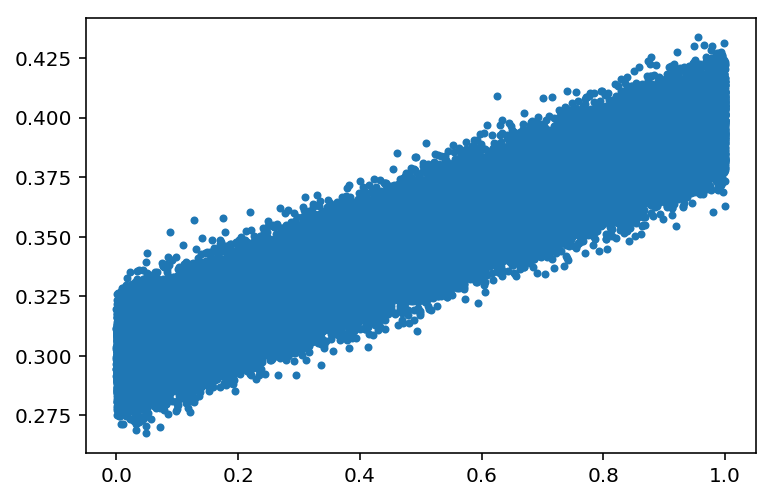

In [6]:
x_train = np.random.rand(num_samples).astype(np.float32)
print(x_train)

noise = np.random.normal(scale=0.01, size=len(x_train))

y_train = x_train * 0.1 + 0.3 + noise
print(y_train)

pylab.plot(x_train, y_train, '.')

[0.18428813 0.704835   0.93404216 ... 0.01131399 0.16563207 0.17122911]
[0.31826294 0.37738616 0.39754194 ... 0.29715469 0.30882735 0.31901889]


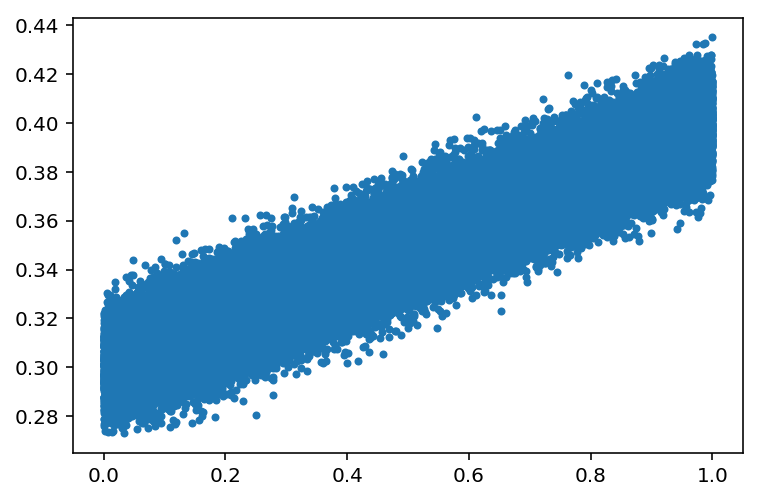

In [7]:
x_test = np.random.rand(len(x_train)).astype(np.float32)
print(x_test)

noise = np.random.normal(scale=.01, size=len(x_train))

y_test = x_test * 0.1 + 0.3 + noise
print(y_test)

pylab.plot(x_test, y_test, '.')

In [8]:
with tf.device("/cpu:0"):
    W = tf.get_variable(shape=[], name='weights')
    print(W)

    b = tf.get_variable(shape=[], name='bias')
    print(b)

with tf.device("/gpu:0"):            
    x_observed = tf.placeholder(shape=[None], 
                                dtype=tf.float32, 
                                name='x_observed')
    print(x_observed)

    y_pred = W * x_observed + b
    print(y_pred)

<tf.Variable 'weights:0' shape=() dtype=float32_ref>
<tf.Variable 'bias:0' shape=() dtype=float32_ref>
Tensor("x_observed:0", shape=(?,), dtype=float32, device=/device:GPU:0)
Tensor("add:0", shape=(?,), dtype=float32, device=/device:GPU:0)


In [9]:
learning_rate = 0.025

with tf.device("/gpu:0"):
    y_observed = tf.placeholder(shape=[None], dtype=tf.float32, name='y_observed')
    print(y_observed)

    loss_op = tf.reduce_mean(tf.square(y_pred - y_observed))
    optimizer_op = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer_op.minimize(loss_op)  

    print("Loss Scalar: ", loss_op)
    print("Optimizer Op: ", optimizer_op)
    print("Train Op: ", train_op)

Tensor("y_observed:0", shape=(?,), dtype=float32, device=/device:GPU:0)
Loss Scalar:  Tensor("Mean:0", shape=(), dtype=float32, device=/device:GPU:0)
Optimizer Op:  <tensorflow.python.training.gradient_descent.GradientDescentOptimizer object at 0x7f732806ec88>
Train Op:  name: "GradientDescent"
op: "NoOp"
input: "^GradientDescent/update_weights/ApplyGradientDescent"
input: "^GradientDescent/update_bias/ApplyGradientDescent"
device: "/device:CPU:0"



## Randomly Initialize Variables (Weights and Bias)
The goal is to learn more accurate Weights and Bias during training.

In [10]:
with tf.device("/cpu:0"):
    init_op = tf.global_variables_initializer()
    print(init_op)

name: "init"
op: "NoOp"
input: "^weights/Assign"
input: "^bias/Assign"
device: "/device:CPU:0"



In [11]:
sess.run(init_op)
print("Initial random W: %f" % sess.run(W))
print("Initial random b: %f" % sess.run(b))

Initial random W: 0.399219
Initial random b: -1.128793


## View Accuracy of Pre-Training, Initial Random Variables
We want this to be close to 0, but it's relatively far away.  This is why we train!

In [12]:
def test(x, y):
    return sess.run(loss_op, feed_dict={x_observed: x, y_observed: y})

In [13]:
test(x_test, y_test)

1.6453182

## Setup Loss Summary Operations for Tensorboard

In [14]:
loss_summary_scalar_op = tf.summary.scalar('loss', loss_op)
loss_summary_merge_all_op = tf.summary.merge_all()

In [15]:
train_summary_writer = tf.summary.FileWriter('/root/pipelineai/models/optimize_me/linear/gpu/%s/train' % version, 
                                            graph=tf.get_default_graph())

test_summary_writer = tf.summary.FileWriter('/root/pipelineai/models/optimize_me/linear/gpu/%s/test' % version,
                                            graph=tf.get_default_graph())

## Train Model

In [16]:
%%time

with tf.device("/gpu:0"):
    run_metadata = tf.RunMetadata()
    max_steps = 401
    for step in range(max_steps):
        if (step < max_steps - 1):
            test_summary_log, _ = sess.run([loss_summary_merge_all_op, loss_op], feed_dict={x_observed: x_test, y_observed: y_test})
            train_summary_log, _ = sess.run([loss_summary_merge_all_op, train_op], feed_dict={x_observed: x_train, y_observed: y_train})
        else:  
            test_summary_log, _ = sess.run([loss_summary_merge_all_op, loss_op], feed_dict={x_observed: x_test, y_observed: y_test})
            train_summary_log, _ = sess.run([loss_summary_merge_all_op, train_op], feed_dict={x_observed: x_train, y_observed: y_train}, 
                                            options=tf.RunOptions(trace_level=tf.RunOptions.SOFTWARE_TRACE), 
                                            run_metadata=run_metadata)

            trace = timeline.Timeline(step_stats=run_metadata.step_stats)    
            with open('timeline-gpu.json', 'w') as trace_file:
                trace_file.write(trace.generate_chrome_trace_format(show_memory=True))

        if step % 10 == 0:
            print(step, sess.run([W, b]))
            train_summary_writer.add_summary(train_summary_log, step)
            train_summary_writer.flush()
            test_summary_writer.add_summary(test_summary_log, step)
            test_summary_writer.flush()

0 [0.4299599, -1.0648361]
10 [0.64078844, -0.6068078]
20 [0.73832625, -0.36244518]
30 [0.77739894, -0.22928941]
40 [0.7864756, -0.15410689]
50 [0.78033364, -0.10923624]
60 [0.766638, -0.08030121]
70 [0.74935925, -0.059827223]
80 [0.7305489, -0.043925386]
90 [0.7112622, -0.030569661]
100 [0.6920367, -0.018701997]
110 [0.67314196, -0.0077673607]
120 [0.6547079, 0.002527778]
130 [0.63679296, 0.012340937]
140 [0.61941844, 0.021758799]
150 [0.6025864, 0.03083109]
160 [0.5862896, 0.039588198]
170 [0.570516, 0.04805031]
180 [0.5552513, 0.05623218]
190 [0.5404805, 0.064145595]
200 [0.5261883, 0.07180065]
210 [0.5123595, 0.07920648]
220 [0.4989793, 0.086371556]
230 [0.48603332, 0.09330385]
240 [0.47350737, 0.10001104]
250 [0.46138802, 0.1065005]
260 [0.44966197, 0.112779304]
270 [0.4383165, 0.1188543]
280 [0.42733923, 0.12473213]
290 [0.41671824, 0.13041916]
300 [0.40644196, 0.13592164]
310 [0.39649922, 0.14124551]
320 [0.3868792, 0.14639659]
330 [0.3775714, 0.1513805]
340 [0.36856565, 0.156202

(0, 1.0)

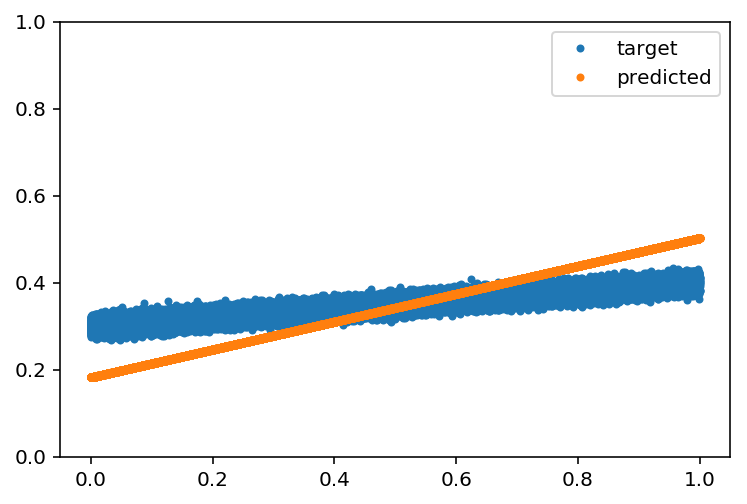

In [17]:
pylab.plot(x_train, y_train, '.', label="target")
pylab.plot(x_train, sess.run(y_pred, 
                             feed_dict={x_observed: x_train, 
                                        y_observed: y_train}), 
           ".", 
           label="predicted")
pylab.legend()
pylab.ylim(0, 1.0)

## View Loss Summaries in Tensorboard
Navigate to the **`Scalars`** and **`Graphs`** tab in your PipelineAI App:

https://[your-ip-address]/admin/tb/

## Save Graph For Optimization
We will use this later.

In [18]:
import os
os.makedirs(name='/root/pipelineai/models/super_optimize_me/linear/gpu', exist_ok=True)
optimize_me_parent_path = '/root/pipelineai/models/super_optimize_me/linear/gpu'

saver = tf.train.Saver()

unoptimized_model_graph_path = '%s/unoptimized_gpu.pb' % optimize_me_parent_path
print(unoptimized_model_graph_path)

tf.train.write_graph(sess.graph_def, 
                     '.', 
                     unoptimized_model_graph_path,
                     as_text=False) 


model_checkpoint_path = '%s/model.ckpt' % optimize_me_parent_path
saver.save(sess, 
           save_path=model_checkpoint_path)
print(model_checkpoint_path)

/root/pipelineai/models/super_optimize_me/linear/gpu/unoptimized_gpu.pb
/root/pipelineai/models/super_optimize_me/linear/gpu/model.ckpt


In [19]:
print(optimize_me_parent_path)
os.listdir(optimize_me_parent_path)

/root/pipelineai/models/super_optimize_me/linear/gpu


['model.ckpt.meta',
 'model.ckpt.index',
 'model.ckpt.data-00000-of-00001',
 'checkpoint',
 'unoptimized_gpu.pb']

In [20]:
sess.close()

## Show Graph

In [21]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import re
from google.protobuf import text_format
from tensorflow.core.framework import graph_pb2

def convert_graph_to_dot(input_graph, output_dot, is_input_graph_binary):
    graph = graph_pb2.GraphDef()
    with open(input_graph, "rb") as fh:
        if is_input_graph_binary:
            graph.ParseFromString(fh.read())
        else:
            text_format.Merge(fh.read(), graph)
    with open(output_dot, "wt") as fh:
        print("digraph graphname {", file=fh)
        for node in graph.node:
            output_name = node.name
            print("  \"" + output_name + "\" [label=\"" + node.op + "\"];", file=fh)
            for input_full_name in node.input:
                parts = input_full_name.split(":")
                input_name = re.sub(r"^\^", "", parts[0])
                print("  \"" + input_name + "\" -> \"" + output_name + "\";", file=fh)
        print("}", file=fh)
        print("Created dot file '%s' for graph '%s'." % (output_dot, input_graph))
        

In [22]:
input_graph='/root/pipelineai/models/optimize_me/linear/gpu/unoptimized_gpu.pb'
output_dot='./unoptimized_gpu.dot'
convert_graph_to_dot(input_graph=input_graph, output_dot=output_dot, is_input_graph_binary=True)

Created dot file './unoptimized_gpu.dot' for graph '/root/pipelineai/models/optimize_me/linear/gpu/unoptimized_gpu.pb'.


In [23]:
%%bash

dot -T png ./unoptimized_gpu.dot \
    -o ./unoptimized_gpu.png > /tmp/a.out

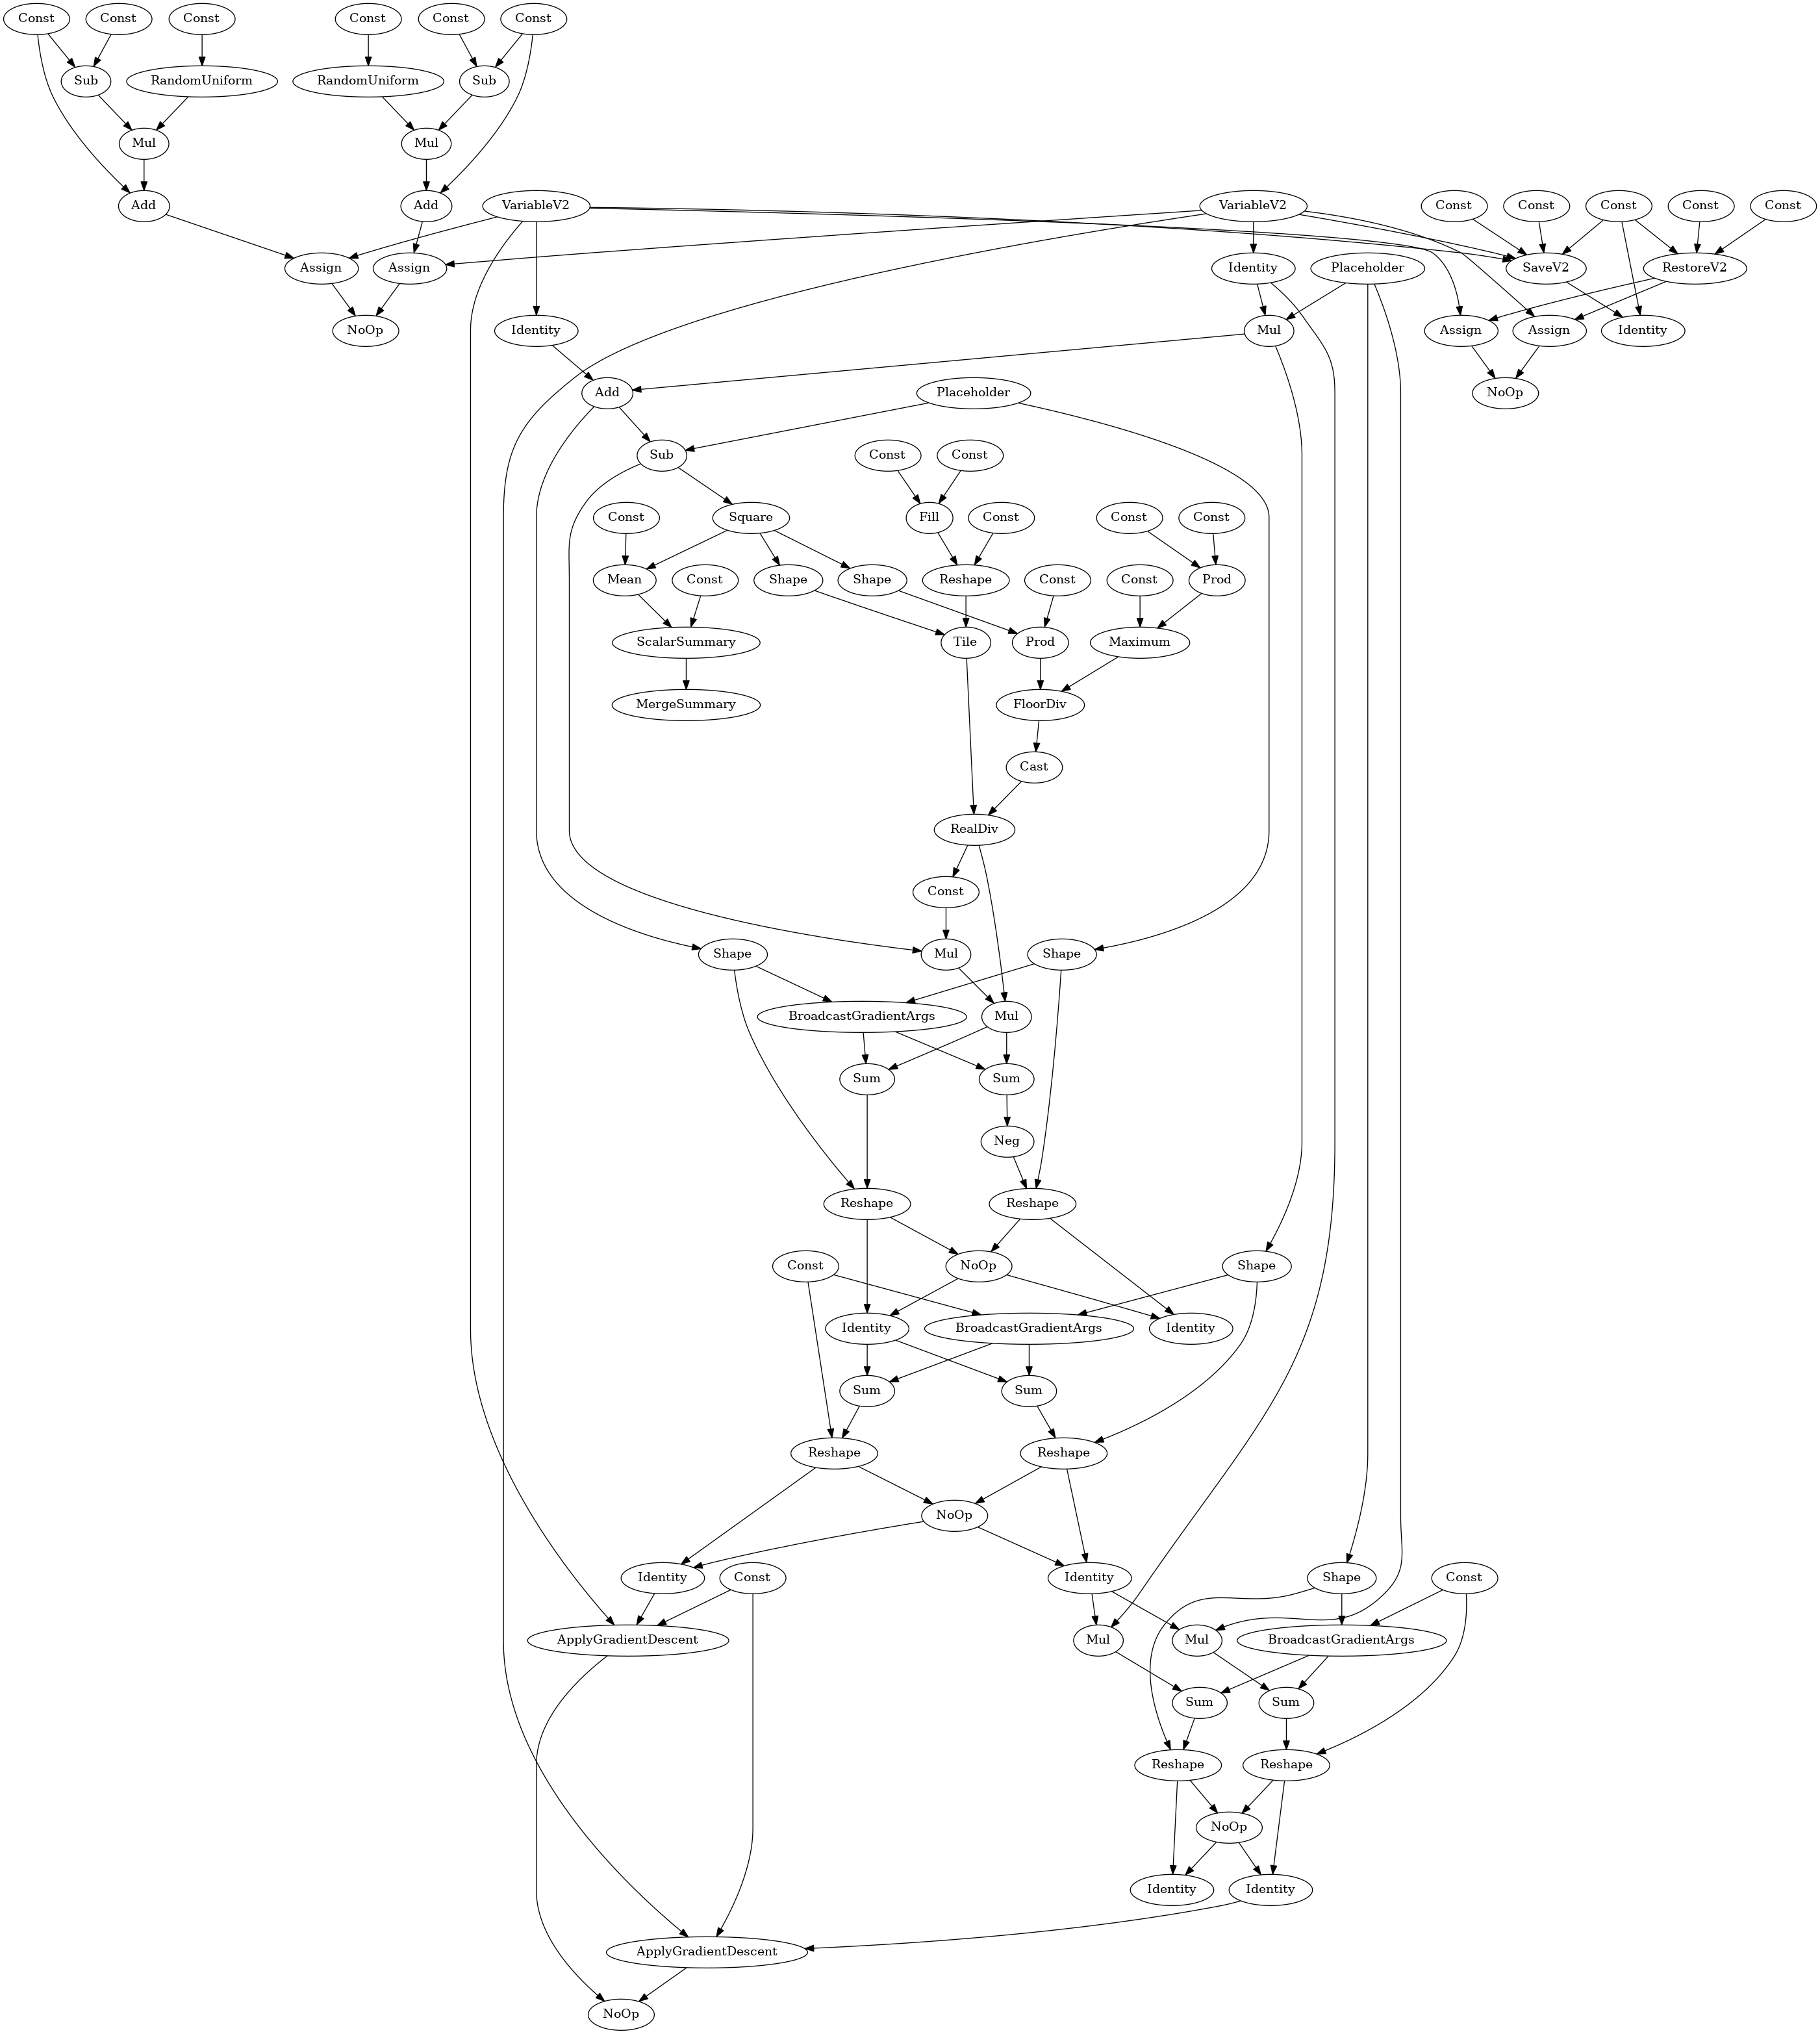

In [24]:
from IPython.display import Image

Image('./unoptimized_gpu.png', width=1024, height=768)

In [1]:
import subprocess

saved_model_path = '/root/pipelineai/models/optimize_me/saved_model/linear/cpu/%s' % version

output = subprocess.run(["saved_model_cli", "show", \
                "--dir", saved_model_path, "--all"], \
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE)

print(output.stdout.decode('utf-8'))

NameError: name 'version' is not defined

In [2]:
import tensorflow as tf

converter = tf.contrib.lite.TocoConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


NameError: name 'saved_model_path' is not defined

In [ ]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.contrib.lite.Interpreter(model_path="converted_model.tflite")
interpreter.allocate_tensors()

In [ ]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

In [ ]:
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)